In [273]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [296]:
def find_center_road(slice_img, dir=0):
    line_type = 8
    thickness = 3
    radius = 2
    index = 0
    test_img = np.zeros((240,320,3), dtype='uint8')
    for image in slice_img:
        im, contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            M = cv2.moments(contour);
            if (M['m00'] > 10):
                if (dir == 0):
                    x = int(M['m10']/M['m00'])
                    y = int(M['m01']/M['m00']) + index * image.shape[0]
                else:
                    x = int(M['m10']/M['m00']) + index * image.shape[1]
                    y = int(M['m01']/M['m00']) 
                #print(y, index * thickness)
                cv2.circle(test_img, (x, y), radius, (0,255,0), thickness, line_type, 0)    
        index += 1
    plt.imshow(test_img)
    plt.show() 

In [297]:
def filllane(img):
    lines = cv2.HoughLinesP(img, 1, np.pi/180,1) # Dùng phép biến đổi Hough để tìm đường thẳng
    if lines is not None: 
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2,y2), 255, 3, cv2.LINE_AA)

In [298]:
skyline = 85
birdview_width = 240
birdview_height = 320
def BirdViewTransform(mask):
    width = mask.shape[1]
    height = mask.shape[0]
    src_vertices = np.array([[0, skyline],
                             [width,skyline],
                             [width, height],
                             [0,height]], dtype = "float32")
    dst_vertices = np.array([[0,0],
                             [birdview_width,0],
                             [birdview_width - 105, birdview_height],
                             [105, birdview_height]], dtype = "float32")
    M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    warped = cv2.warpPerspective(mask, M, (birdview_width, birdview_height))
    return warped

In [299]:
def slice_image(normal_img, dir=0):
    img_height = normal_img.shape[0]
    img_width = normal_img.shape[1]
    slice_thickness = 10
    slice_img = []
    if (dir == 0):
        for i in range(0, img_height, slice_thickness):
            slice_img.append(normal_img[i:i+slice_thickness,:])
    else:
        for i in range(0, img_width, slice_thickness):
            slice_img.append(normal_img[:,i:i+slice_thickness])
    return slice_img

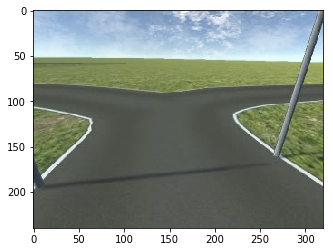

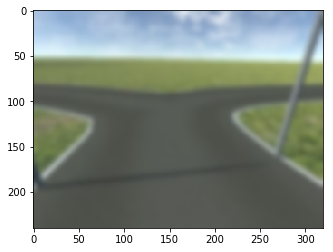

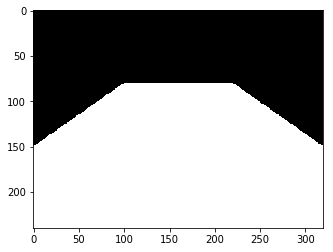

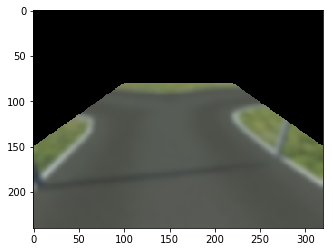

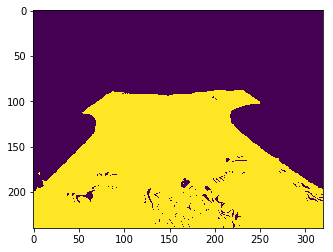

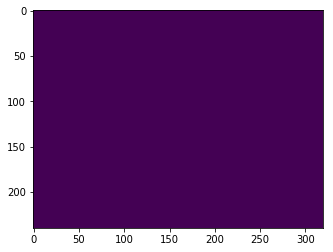

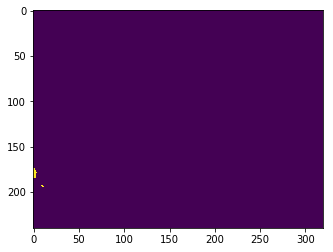

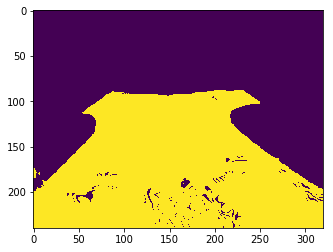

(225, 1, 2)


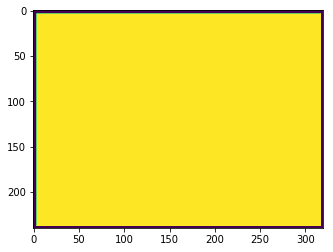

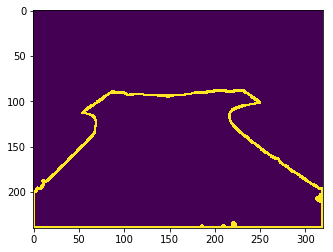

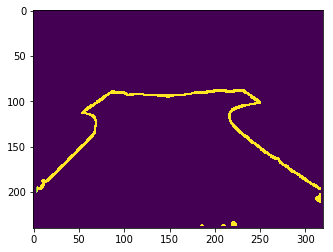

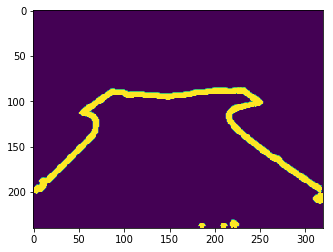

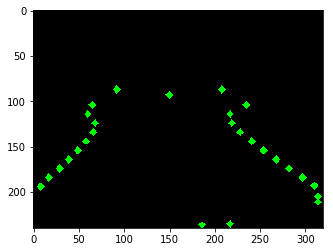

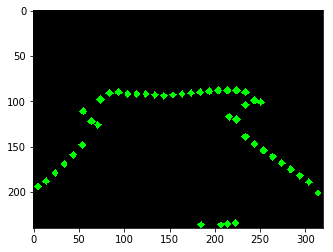

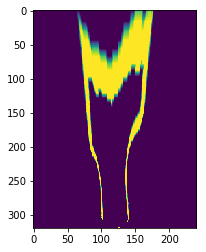

In [301]:
img = cv2.imread("Lane_image/IMG_733.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
blur_img = cv2.GaussianBlur(img,(17,17),0)
plt.imshow(blur_img)
plt.show()
list_point = np.array(((0,240),(0,150),(100,80), (220,80), (320,150), (320,240)))
maskROI = np.zeros((240,320,3), dtype='uint8')
cv2.fillConvexPoly(maskROI, list_point, (255,255,255))
plt.imshow(maskROI)
plt.show()
blur_img = cv2.bitwise_and(maskROI, blur_img)
plt.imshow(blur_img)
plt.show()
hsv_img = cv2.cvtColor(blur_img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_img, (41,5,53), (93,31,102))
plt.imshow(mask)
plt.show()
mask2 = cv2.inRange(hsv_img, (20,56,43), (35,77,64))
plt.imshow(mask2)
plt.show()
maskShadow = cv2.inRange(hsv_img, (70,18,12), (137,155,74))
plt.imshow(maskShadow)
plt.show()
maskCombined = cv2.bitwise_or(mask,mask2)
maskCombined = cv2.bitwise_or(maskCombined,maskShadow)
plt.imshow(maskCombined)
plt.show()
im2,contours,hierarchy = cv2.findContours(maskCombined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
maskLane = np.zeros_like(maskCombined)
max_area = 0
for contour in contours:
    if (max_area < cv2.contourArea(contour)):
        max_contour = contour
        max_area = cv2.contourArea(contour)
print(max_contour.shape)
list_point = np.array(((0,240),(0,0),(320,0), (320,240)))
maskEdge = np.zeros((240,320), dtype='uint8')
cv2.fillConvexPoly(maskEdge, list_point, 255)
cv2.line(maskEdge, (0,240), (0,0), 0, 4, cv2.LINE_AA)
cv2.line(maskEdge, (320,0), (0,0), 0, 4, cv2.LINE_AA)
cv2.line(maskEdge, (320,0), (320,240), 0, 4, cv2.LINE_AA)
cv2.line(maskEdge, (0,240), (320,240), 0, 4, cv2.LINE_AA)
plt.imshow(maskEdge)
plt.show()
#hull = cv2.convexHull(max_contour, False)
cv2.drawContours(maskLane, [max_contour], -1, 255, 2)
#cv2.drawContours(maskLane, [hull], -1, 255, 3)
plt.imshow(maskLane)
plt.show()
maskLane = cv2.bitwise_and(maskLane,maskEdge)
plt.imshow(maskLane)
plt.show()
filllane(maskLane)
plt.imshow(maskLane)
plt.show()
# Slice image vertically
slice_img = slice_image(maskLane, dir=0)
#for image in slice_img:
#    plt.imshow(image)
#    plt.show()
find_center_road(slice_img, dir=0)
# Slice image horizontally
slice_img = slice_image(maskLane, dir=1)
#for image in slice_img:
#    plt.imshow(image)
#    plt.show()
find_center_road(slice_img, dir=1)
# BirdViewTransform
birdview_img = BirdViewTransform(maskLane)
plt.imshow(birdview_img)
plt.show()

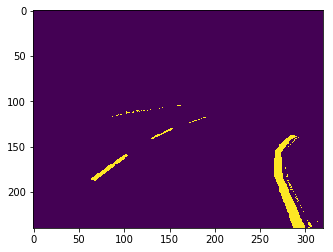

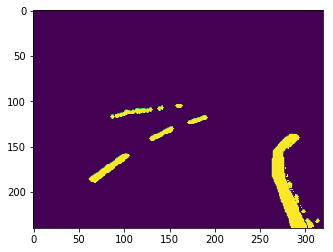

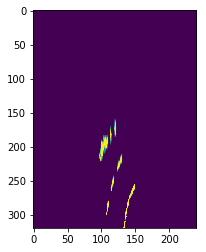

In [279]:
imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV);
imgThresholded = cv2.inRange(imgHSV, (0, 0, 180), (179, 30, 255));
maskShadow = cv2.inRange(imgHSV, (90, 43, 97), (120, 80, 171));
maskCombined = cv2.bitwise_or(imgThresholded, maskShadow);
list_point = np.array(((0,240),(0,150),(120,105), (200,105), (320,150), (320,240)))
#print(list_point)
maskROI = np.zeros((240,320), dtype='uint8')
cv2.fillConvexPoly(maskROI, list_point, 255);
maskCombined = cv2.bitwise_and(maskCombined, maskROI);
plt.imshow(maskCombined); 
plt.show()
filllane(maskCombined);
plt.imshow(maskCombined); 
plt.show()
dst = BirdViewTransform(maskCombined);
plt.imshow(dst);
plt.show()